In [18]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [24]:
DATA_ROOT = "Data" 
pattern = re.compile(r"benchmark_(.+?)_(.+?)_(cpu|cuda)\.csv")
averages = defaultdict(lambda: {})


In [26]:
for user in os.listdir(DATA_ROOT):
    user_path = os.path.join(DATA_ROOT, user)
    if not os.path.isdir(user_path):
        continue

    for fname in os.listdir(user_path):
        match = pattern.match(fname)
        if not match:
            continue

        user_name, model, device = match.groups()
        file_path = os.path.join(user_path, fname)

        df = pd.read_csv(file_path)

        # Compute averages
        avg = {
            "WER": df["WER"].mean(),
            "RTF": df["RTF"].mean(),
            "CPU_%": df["CPU_%"].mean(),
            "Mem_MB": df["Mem_MB"].mean(),
        }

        # GPU metrics only for cuda devices
        if device == "cuda":
            avg["GPU_MB_avg"] = df["GPU_MB_avg"].mean()
            avg["GPU_MB_peak"] = df["GPU_MB_peak"].mean()

        averages[(model, device)][user] = avg



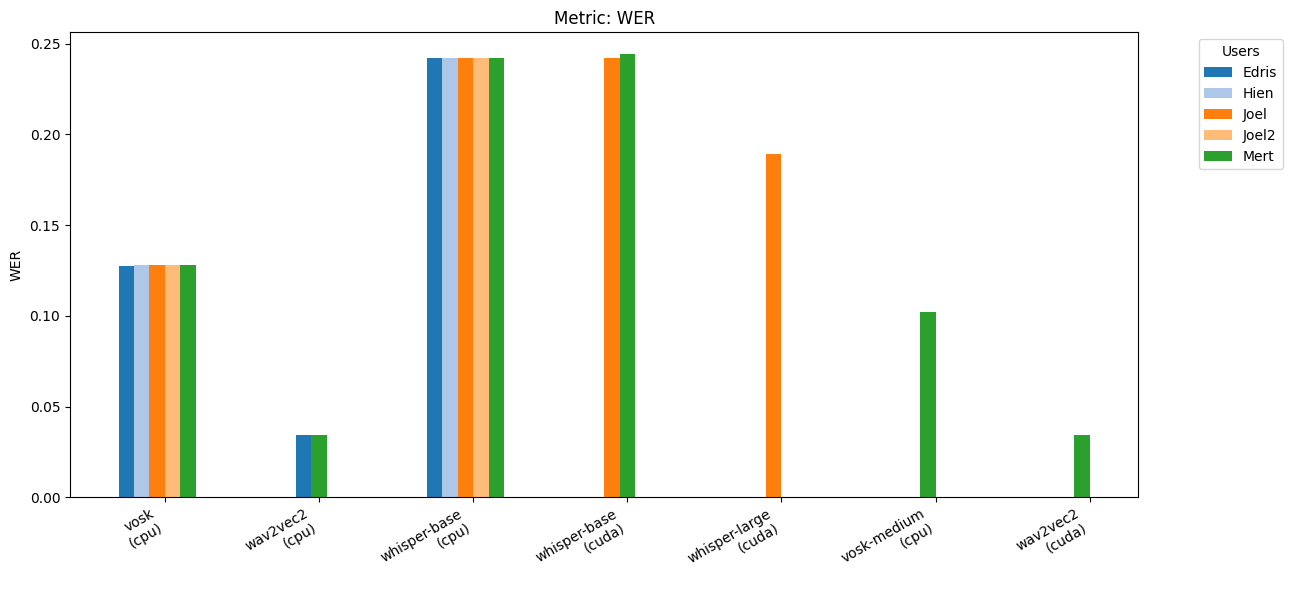

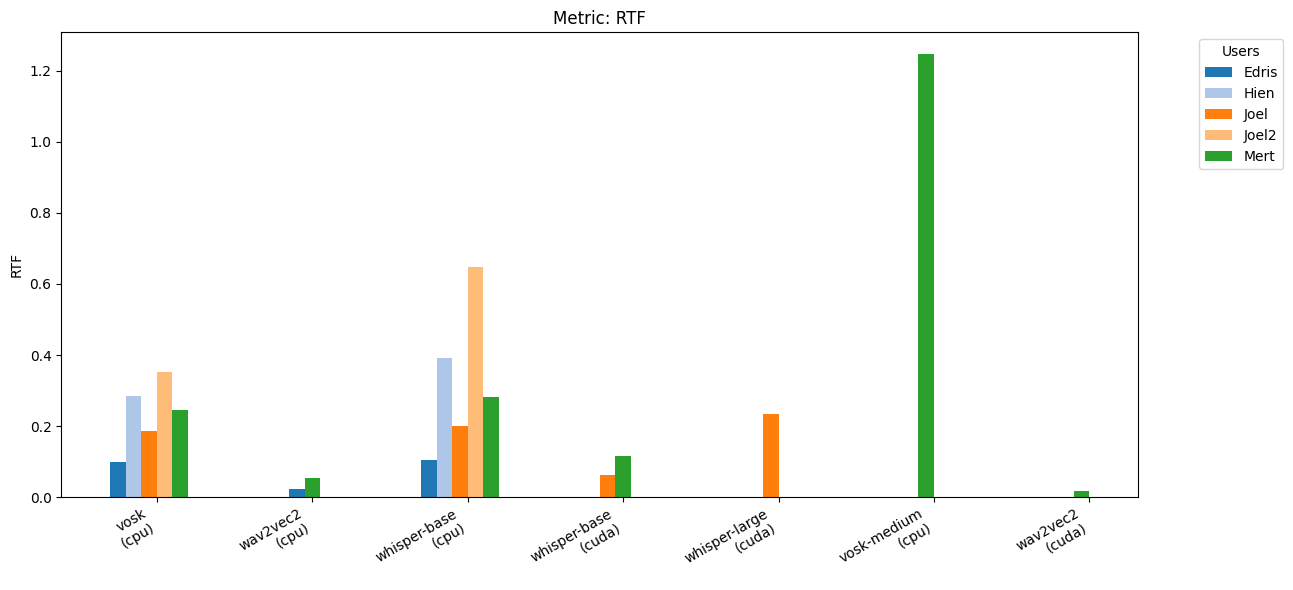

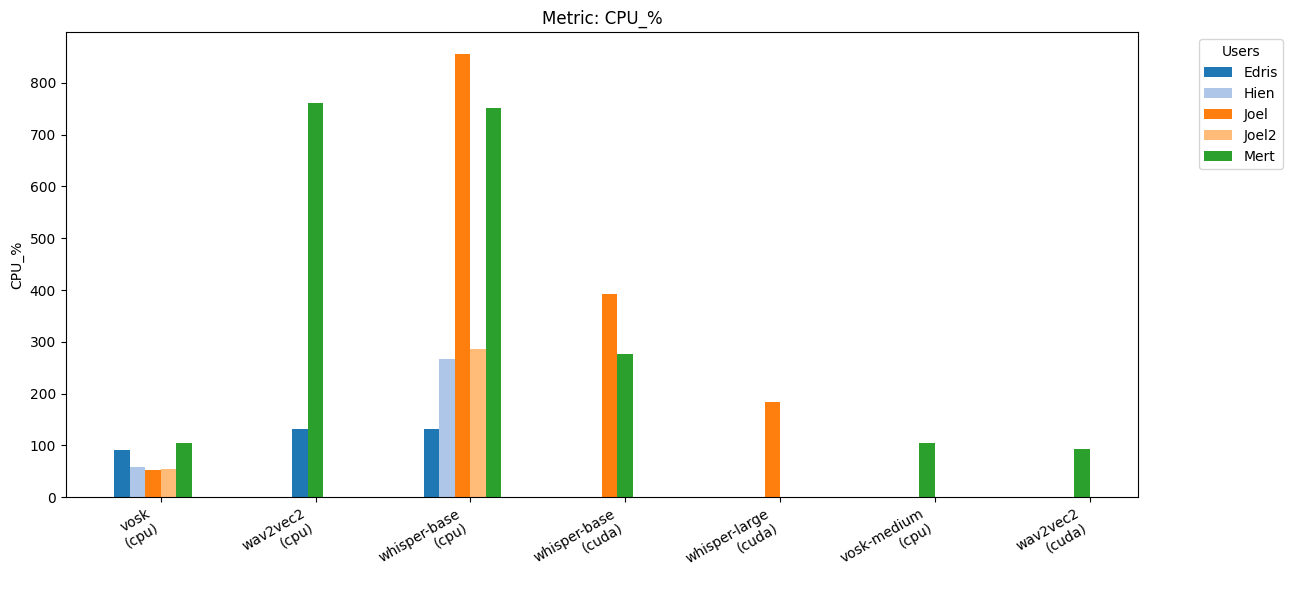

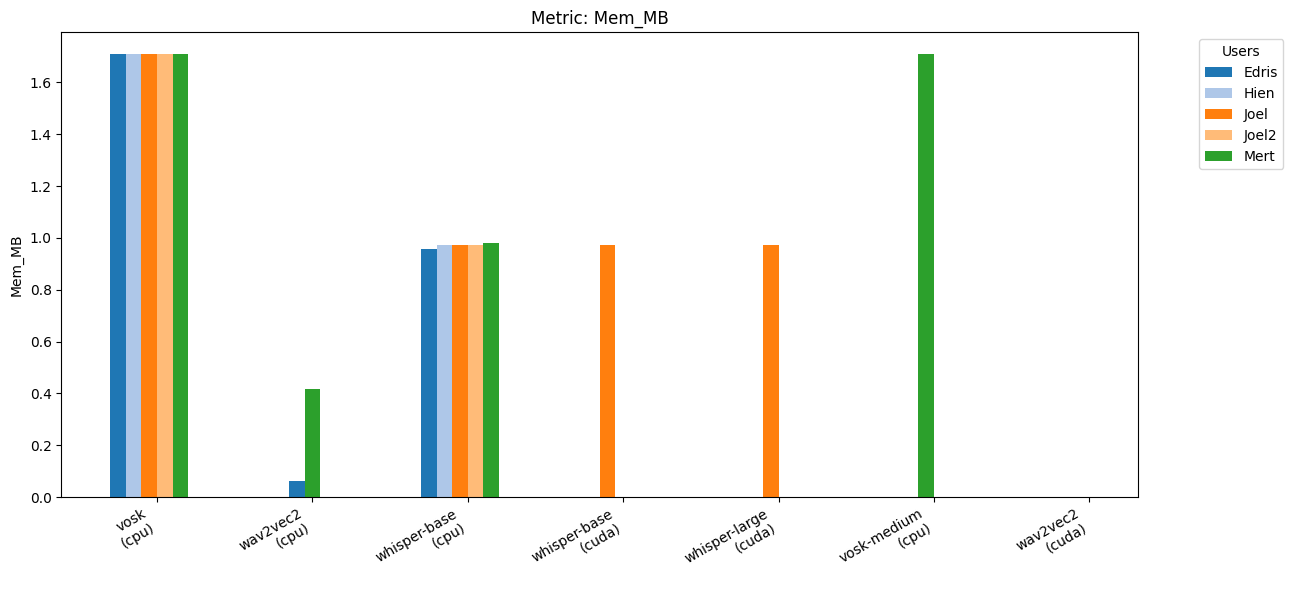

C:\Users\Mert\AppData\Local\Temp\ipykernel_22536\622456909.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Users", bbox_to_anchor=(1.05, 1), loc="upper left")


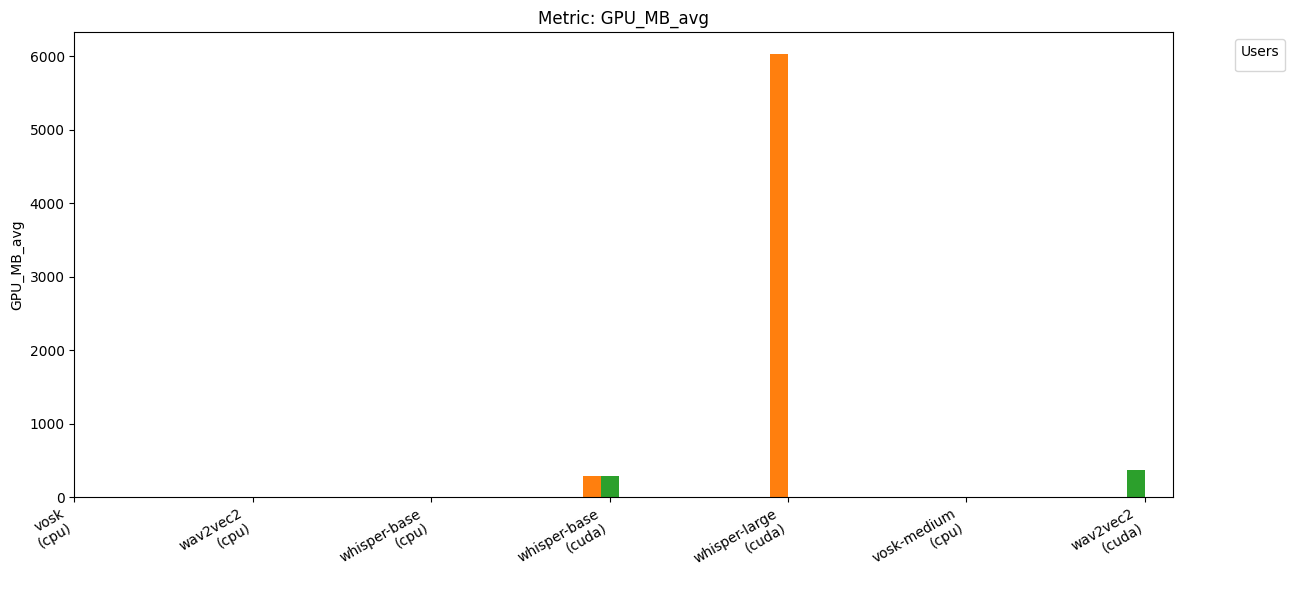

C:\Users\Mert\AppData\Local\Temp\ipykernel_22536\622456909.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Users", bbox_to_anchor=(1.05, 1), loc="upper left")


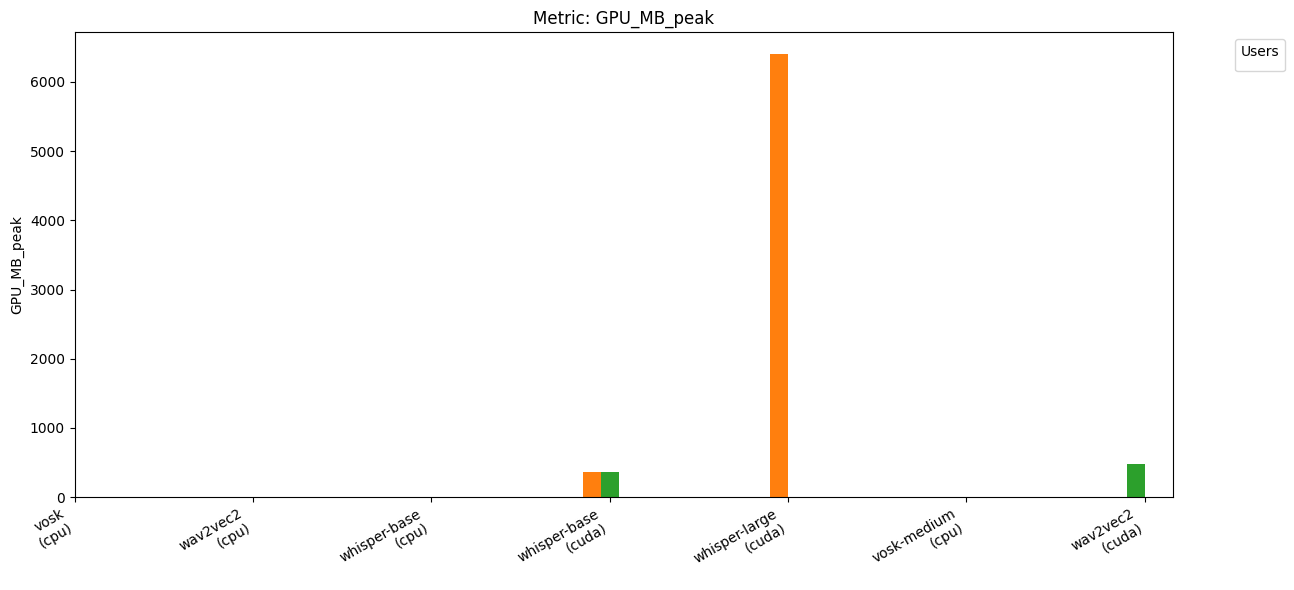

In [29]:
# ----------------------------------------------------
# STEP 2 — Plots with:
#  - Fixed bar width for all sub-columns
#  - No gaps when users are missing
#  - Consistent user colors across plots
# ----------------------------------------------------

metrics = ["WER", "RTF", "CPU_%", "Mem_MB", "GPU_MB_avg", "GPU_MB_peak"]

# Global users for consistent colors
all_users = sorted({
    user
    for combo in averages.values()
    for user in combo.keys()
})

color_map = {user: plt.cm.tab20(i % 20) for i, user in enumerate(all_users)}

# FIXED WIDTH for *all* subcolumns everywhere
BAR_WIDTH = 0.1     # adjust if needed

for metric in metrics:

    # Skip metrics not present anywhere
    has_any = any(
        metric in user_metrics
        for combo in averages.values()
        for user_metrics in combo.values()
    )
    if not has_any:
        continue

    plt.figure(figsize=(13, 6))
    plt.title(f"Metric: {metric}")
    plt.ylabel(metric)

    groups = list(averages.keys())  # (model, device)

    for i, (model, device) in enumerate(groups):
        group_data = averages[(model, device)]

        # Users who actually have data for this metric in this group
        present_users = [
            u for u in all_users
            if u in group_data and metric in group_data[u]
        ]

        n_present = len(present_users)
        if n_present == 0:
            continue

        # Compute the total width & center bars so they align under the main column
        total_width = BAR_WIDTH * n_present
        start_x = i - total_width / 2

        for j, user in enumerate(present_users):
            x = start_x + j * BAR_WIDTH
            value = group_data[user][metric]

            plt.bar(
                x, value,
                width=BAR_WIDTH,
                color=color_map[user],
                label=user if i == 0 else None
            )

    plt.xticks(
        range(len(groups)),
        [f"{m}\n({d})" for (m, d) in groups],
        rotation=30,
        ha="right"
    )

    plt.legend(title="Users", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()